### Missing value guideline
- https://www.kaggle.com/alexisbcook/missing-values

In [1]:
# Basic library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Feature Selection
from scipy.stats import chi2_contingency

import pickle

# Evaluation
# from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
import sys
import numpy as np
import matplotlib
import seaborn as sns
import tqdm
import sklearn
import pandas


print ( "Python", sys.version )
print ( "Numpy", np.__version__ )
print ( "Matplotlib", matplotlib.__version__ )
print ( "Seaborn", sns.__version__ )
print ( "tqdm", tqdm.__version__ )
print ( "scikit-learn", sklearn.__version__ )
print ( "pandas", pandas.__version__ )



Python 3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy 1.17.3
Matplotlib 3.0.3
Seaborn 0.9.0
tqdm 4.40.0
scikit-learn 0.22.1
pandas 0.25.3


In [3]:
# Set dataframe display
pd.set_option('display.max_columns', None)  # default = 20
pd.set_option('display.expand_frame_repr', False) # default = True
pd.set_option('display.max_colwidth', -1) # default = 50
pd.set_option('display.max_rows', None) # default = 60
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def percent_countplot(df, col_name, col_hue = None, order_by_value = False, topn = 20, dropna = True,
                      orient = 'v', annot_percent = True, figsize = (14,8)):
    
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Fill Paramter
    fs = 16 # Font size
    x_data = df.copy()
    x_col = col_name # column to count
    x_hue = col_hue # For divide column
    tittle = 'Distribution by '+x_col

    matplotlib.rc('xtick', labelsize = fs-2)     
    matplotlib.rc('ytick', labelsize = fs-2)
    fig = plt.figure(figsize= figsize)
    
    data_col = x_data   
        
    # topn > 0 we will combine the rest as "Other"
    if topn:
        counts = data_col[x_col].value_counts()
        topn_name = counts.nlargest(topn).index
        data_col[x_col] = data_col[x_col].where(data_col[x_col].isin(topn_name), other = 'Other')
    elif topn == 0:
        topn = data_col[x_col].nunique()
        
    # arrange order by value or index?
    if order_by_value :
        counts = data_col[x_col].value_counts()
        max_count = max(counts) # for adjust text alignment
    else:
        if str in list(map(type,data_col[x_col])) or not dropna:
            data_col[x_col] = data_col[x_col].astype(str)
        counts = data_col[x_col].value_counts().sort_index()
        max_count = max(counts.iloc[:topn]) # for adjust text alignment
        
    if orient == 'v':
        ax = sns.countplot(x = x_col, hue = x_hue, data= data_col, order = counts.iloc[:topn+1].index)
        ax.set_xlabel(x_col, color = 'r', fontsize = fs, fontweight='bold')
        ax.set_ylabel('Frequency', color = 'b', fontsize = fs, fontweight='bold')
        # Set rotation of xticks if name is too long
        data_col[x_col] = data_col[x_col].astype(str)
        xrot = 15 if max(list(map(len,data_col[x_col].unique()))) > 10 else 0
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    elif orient == 'h':
        ax = sns.countplot(y = x_col, hue = x_hue, data= data_col, order = counts.iloc[:topn+1].index)
        ax.set_ylabel(x_col, color = 'b', fontsize = fs, fontweight='bold')
        ax.set_xlabel('Frequency', color = 'r', fontsize = fs, fontweight='bold')
        xrot = 0
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        
    total_count = sum(counts) # for calculate percentage
    # print(counts)
    
    # fig.suptitle('test title', fontsize=12)
    ax.set_title(tittle, fontsize = fs, fontweight='bold' )

    plt.xticks(rotation=xrot, color='r', size=16)
    plt.yticks(rotation=0, color='b', size=16)
    
    if x_hue == None and orient == 'v':
        for i, v in enumerate(counts[:topn+1]):
            ax.text(x = i, y=v + max_count*0.01 , s='{:,}'.format(v), horizontalalignment='center', color='black', fontweight='bold')
            if annot_percent:
                ax.text(x = i, y= v/2, s=str('{:.2f}'.format(v*100/total_count))+'%',
                        color='yellow', fontweight='bold', size = 14,
                        horizontalalignment='center', 
                        verticalalignment='center' 
                        )
    elif x_hue == None and orient == 'h':
        for i, v in enumerate(counts[:topn+1]):
            ax.text(x = v + max_count*0.03, y=i , s='{:,}'.format(v), horizontalalignment='center', color='black', fontweight='bold')
            if annot_percent:
                ax.text(x = v/2, y=i , s=str('{:.2f}'.format(v*100/total_count))+'%',
                        color='yellow', fontweight='bold', size = 14,
                        horizontalalignment='center', 
                        verticalalignment='center' 
                        )
    return ax

In [5]:
str in list(map(type,['text', 1, 2.00]))

True

In [6]:
df = pd.read_csv('DrugAllergyKaggle_v3_050720.csv')
df = df.sort_values(by = 'Patient_ID').reset_index(drop=True); df.head()

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Score,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
0,2,1,26,2504,0.000,nan,nan,31.000,1,0.000,0,0,0.000,0.000,2,2.000,2,nan
1,7,0,75,1868,51.000,5.000,2.000,1.000,0,0.000,0,0,0.000,0.000,2,6.000,4,1.000
2,13,0,81,1617,10.000,nan,nan,19.000,1,1.000,0,0,1.000,1.000,2,5.000,1,nan
3,13,0,81,1617,10.000,nan,nan,19.000,1,1.000,0,0,1.000,1.000,2,5.000,3,nan
4,18,1,60,3136,0.000,nan,nan,nan,0,0.000,0,0,1.000,1.000,3,8.000,1,nan


In [7]:
df[df.Drug_Rechallenge_Result.isnull()].head()

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Score,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
0,2,1,26,2504,0.000,nan,nan,31.000,1,0.000,0,0,0.000,0.000,2,2.000,2,nan
2,13,0,81,1617,10.000,nan,nan,19.000,1,1.000,0,0,1.000,1.000,2,5.000,1,nan
3,13,0,81,1617,10.000,nan,nan,19.000,1,1.000,0,0,1.000,1.000,2,5.000,3,nan
4,18,1,60,3136,0.000,nan,nan,nan,0,0.000,0,0,1.000,1.000,3,8.000,1,nan
5,18,1,60,3136,0.000,nan,nan,nan,0,0.000,0,0,1.000,1.000,3,8.000,1,nan


In [8]:
df.Drug_Rechallenge_Result.value_counts(dropna=False)

nan      685
0.000    86 
1.000    28 
Name: Drug_Rechallenge_Result, dtype: int64

In [9]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
n_uniq = df.nunique()
print ("\nUnique values :  \n",n_uniq)
print ("\nTotal Unique values :  {:,}".format(n_uniq.values.sum()))

Rows     :  799
Columns  :  18

Features : 
 ['Patient_ID', 'Gender', 'Age_Year', 'ELISpot_Control', 'ELISpot_Result', 'Naranjo_Score', 'Naranjo_Category', 'Exposure_Time', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group', 'Drug_Rechallenge_Result']

Missing values :   1582

Unique values :  
 Patient_ID                 298
Gender                     2  
Age_Year                   94 
ELISpot_Control            261
ELISpot_Result             77 
Naranjo_Score              13 
Naranjo_Category           4  
Exposure_Time              77 
Steroid_Usage              2  
Underlying_Condition_A     2  
Underlying_Condition_B     2  
Underlying_Condition_C     2  
Underlying_Condition_D     2  
Underlying_Condition_E     2  
Suspicion_Score            3  
Allergic_Reaction_Group    8  
Drug_Group                 8  
Drug_Rechallenge_Resu

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 18 columns):
Patient_ID                 799 non-null int64
Gender                     799 non-null int64
Age_Year                   799 non-null int64
ELISpot_Control            799 non-null int64
ELISpot_Result             798 non-null float64
Naranjo_Score              431 non-null float64
Naranjo_Category           509 non-null float64
Exposure_Time              622 non-null float64
Steroid_Usage              799 non-null int64
Underlying_Condition_A     781 non-null float64
Underlying_Condition_B     799 non-null int64
Underlying_Condition_C     799 non-null int64
Underlying_Condition_D     785 non-null float64
Underlying_Condition_E     798 non-null float64
Suspicion_Score            799 non-null int64
Allergic_Reaction_Group    771 non-null float64
Drug_Group                 799 non-null int64
Drug_Rechallenge_Result    114 non-null float64
dtypes: float64(9), int64(9)
memory usage: 112.5 

In [11]:
df.isnull().sum()/len(df) * 100

Patient_ID                0.000 
Gender                    0.000 
Age_Year                  0.000 
ELISpot_Control           0.000 
ELISpot_Result            0.125 
Naranjo_Score             46.058
Naranjo_Category          36.295
Exposure_Time             22.153
Steroid_Usage             0.000 
Underlying_Condition_A    2.253 
Underlying_Condition_B    0.000 
Underlying_Condition_C    0.000 
Underlying_Condition_D    1.752 
Underlying_Condition_E    0.125 
Suspicion_Score           0.000 
Allergic_Reaction_Group   3.504 
Drug_Group                0.000 
Drug_Rechallenge_Result   85.732
dtype: float64

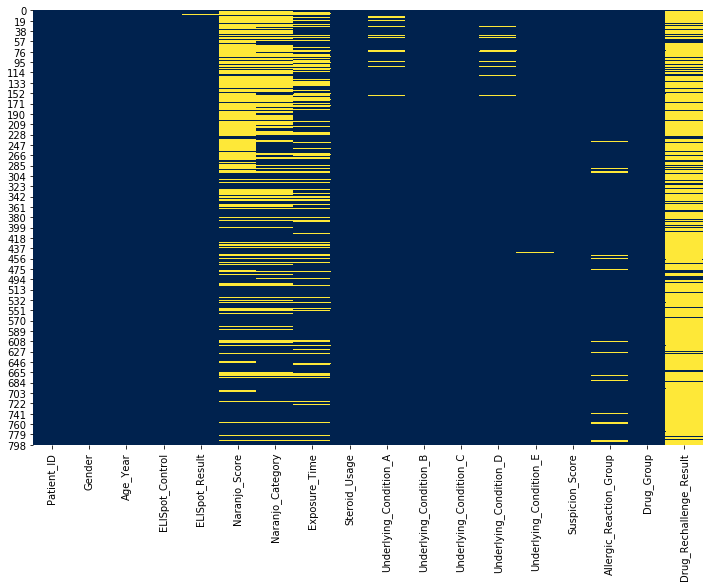

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap = 'cividis');

In [13]:
df.isnull().sum().values.sum()

1582

In [14]:
df.describe(include='all')

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Score,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
count,799.000,799.000,799.000,799.000,798.000,431.000,509.000,622.000,799.000,781.000,799.000,799.000,785.000,798.000,799.000,771.000,799.000,114.000
mean,375.078,0.566,51.013,1698.603,11.974,3.237,1.198,428.534,0.354,0.070,0.100,0.123,0.187,0.326,2.081,4.014,3.826,0.246
std,144.888,0.496,22.345,879.909,51.111,1.797,0.519,3922.749,0.479,0.256,0.300,0.328,0.390,0.469,0.381,2.314,2.514,0.432
min,2.000,0.000,0.000,60.000,0.000,-3.000,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000
25%,318.000,0.000,36.000,1120.000,0.000,2.000,1.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,1.000,0.000
50%,403.000,1.000,53.000,1592.000,0.000,3.000,1.000,10.500,0.000,0.000,0.000,0.000,0.000,0.000,2.000,4.000,3.000,0.000
75%,486.000,1.000,70.000,2166.000,0.000,4.000,1.000,21.000,1.000,0.000,0.000,0.000,0.000,1.000,2.000,6.000,7.000,0.000
max,570.000,1.000,97.000,5290.000,554.000,9.000,3.000,43281.000,1.000,1.000,1.000,1.000,1.000,1.000,3.000,8.000,8.000,1.000


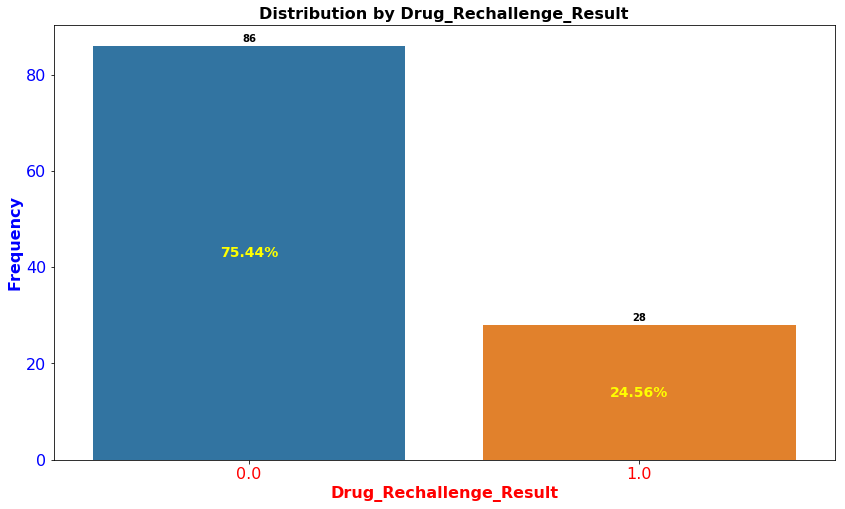

In [15]:
percent_countplot(df,col_name='Drug_Rechallenge_Result', topn=0)

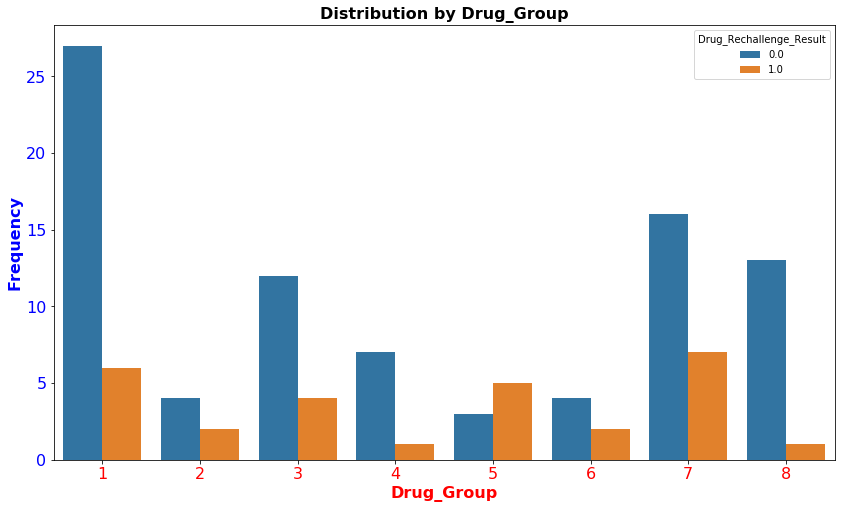

In [16]:
percent_countplot(df,col_name='Drug_Group', col_hue='Drug_Rechallenge_Result')

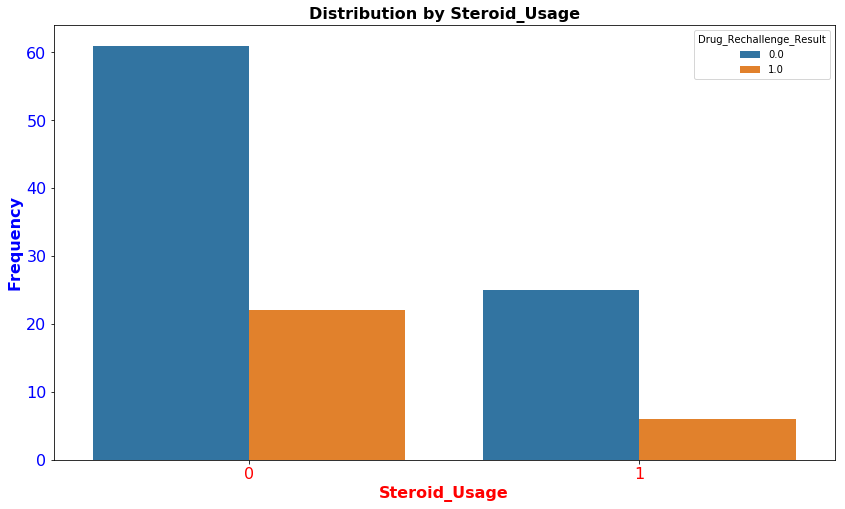

In [17]:
percent_countplot(df,col_name='Steroid_Usage', col_hue='Drug_Rechallenge_Result')

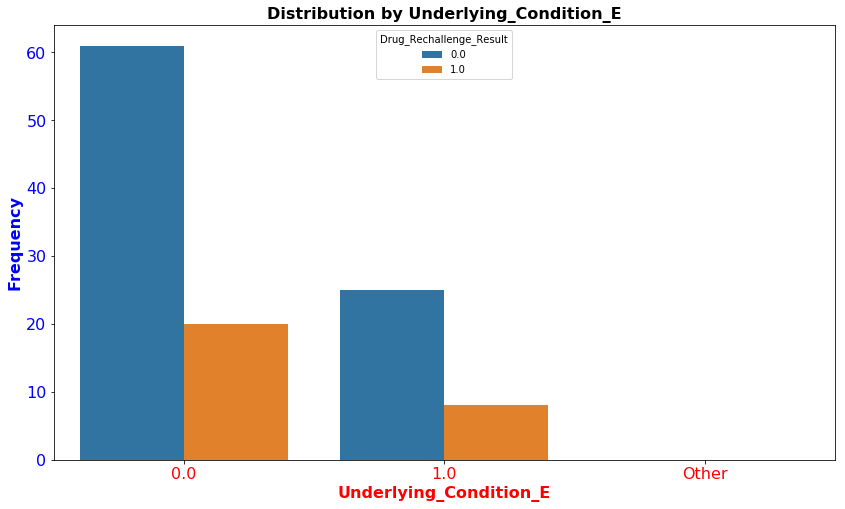

In [18]:
percent_countplot(df,col_name='Underlying_Condition_E', col_hue='Drug_Rechallenge_Result')

# a.) Univariate selection 
**Chi-Square Test:** In general term, this method is used to test the independence of two events. If a dataset is given for two events, we can get the observed count and the expected count and this test measures how much both the counts are derivate from each other.

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1537549804/Image1_c4jcxi.png)

| Feature(X)\Response(y) | Continuous            | Categorical |   |
|------------------------|-----------------------|-------------|---|
| **Continuous**         | Pearson's Correlation | LDA         |   |
| **Categorical**        | ANOVA                 | Chi-Square  |   |

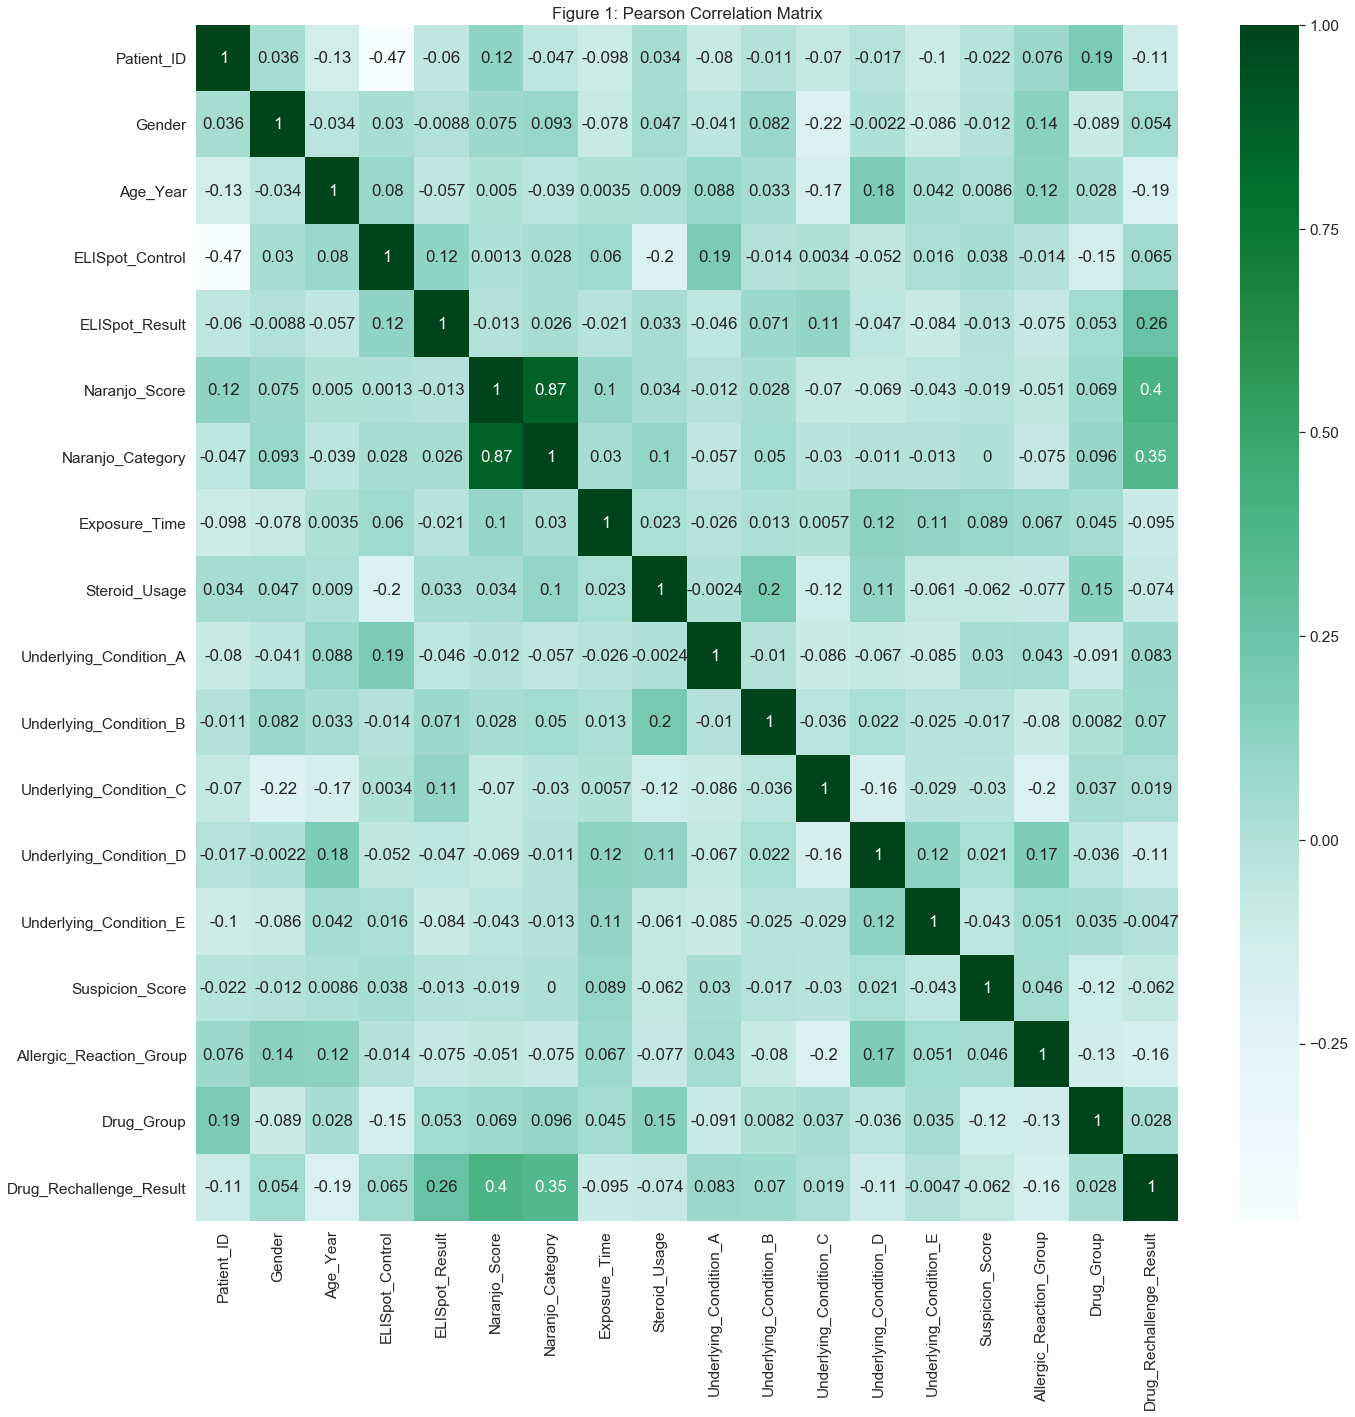

In [19]:
plt.figure(figsize=(22,22)) 
sns.set(font_scale=1.4)
plt.title('Figure 1: Pearson Correlation Matrix')
sns.heatmap(df.corr(), annot=True, cmap='BuGn')

In [20]:
import matplotlib
print ( "Matplotlib", matplotlib.__version__ )

Matplotlib 3.0.3


In [21]:
def chi2_indtest(df_feature, df_target, pvalue = 0.05, verbose =0):
    
    feature_list_chi = []
    feature_list_chi_score = []
    for series in df_feature:
        nl = "\n"

        crosstab = pd.crosstab(df_feature[series], df_target.values.ravel())
        if verbose: print(crosstab, nl)
        chi2, p, dof, expected = chi2_contingency(crosstab)
        if verbose: print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")
        if p < pvalue:
            feature_list_chi.append(series)
            feature_list_chi_score.append(chi2)
    return feature_list_chi, feature_list_chi_score

def plot_feature_importances(df, threshold = 0.90, normalized = True):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index(drop=True)
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    colors = ['b', 'g', 'r', 'c', 'm', 'y','#4ef7ae','#d96d09', '#2b9900','#f7184d', '#1b5c44','#f25e60','#e59400']

    if normalized:
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k',color = colors)
        plt.xlabel('Normalized Importance')
    else:
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance'].head(15), 
                align = 'center', edgecolor = 'k',color = colors)
        plt.xlabel('Importance')
        # Set the xticks format
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(int(x))))
        
#     for i, v in enumerate(df['importance_normalized'].head(15)):
#         ax.text(v + 0.001, i , '{:.4f}'.format(v), color='blue', fontweight='bold')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    
    
    # Plot labeling
    plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    n_fea = len(df)
    ax.plot(np.arange(n_fea)+1, df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    
    if threshold:
        # Index of minimum number of features needed for cumulative importance threshold
        # np.where returns the index so need to add 1 to have correct number
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        plt.vlines(x = importance_index + 1, ymin = 0, ymax = threshold, 
                   linestyles='--', colors = 'blue' )
        plt.text(importance_index +0.02*n_fea, 0, str(importance_index + 1), color='red', fontweight='bold')
        plt.text(importance_index +0.05*n_fea, threshold, str(threshold*100)+'%', color='orange', fontweight='bold')
        plt.show();

    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    
    return df

In [22]:
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nUnique values :  \n",n_uniq)


Features : 
 ['Patient_ID', 'Gender', 'Age_Year', 'ELISpot_Control', 'ELISpot_Result', 'Naranjo_Score', 'Naranjo_Category', 'Exposure_Time', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group', 'Drug_Rechallenge_Result']

Unique values :  
 Patient_ID                 298
Gender                     2  
Age_Year                   94 
ELISpot_Control            261
ELISpot_Result             77 
Naranjo_Score              13 
Naranjo_Category           4  
Exposure_Time              77 
Steroid_Usage              2  
Underlying_Condition_A     2  
Underlying_Condition_B     2  
Underlying_Condition_C     2  
Underlying_Condition_D     2  
Underlying_Condition_E     2  
Suspicion_Score            3  
Allergic_Reaction_Group    8  
Drug_Group                 8  
Drug_Rechallenge_Result    2  
dtype: int64


In [23]:
category_feature = ['Gender','Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group']
target = ['Drug_Rechallenge_Result']

In [24]:
start = time()
pvalue = 1.00 
feature_list_chi, feature_list_chi_score = chi2_indtest(df[category_feature],df[target], pvalue = pvalue)
t = time() - start
print('Execution time = ', t, ' seconds')

print('Select only IMPORTANT feature which p-value less than', pvalue)
print('Number of IMPORTANT feature for Prediction:', len(feature_list_chi), '\n',feature_list_chi)

Execution time =  0.1549220085144043  seconds
Select only IMPORTANT feature which p-value less than 1.0
Number of IMPORTANT feature for Prediction: 11 
 ['Gender', 'Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group']


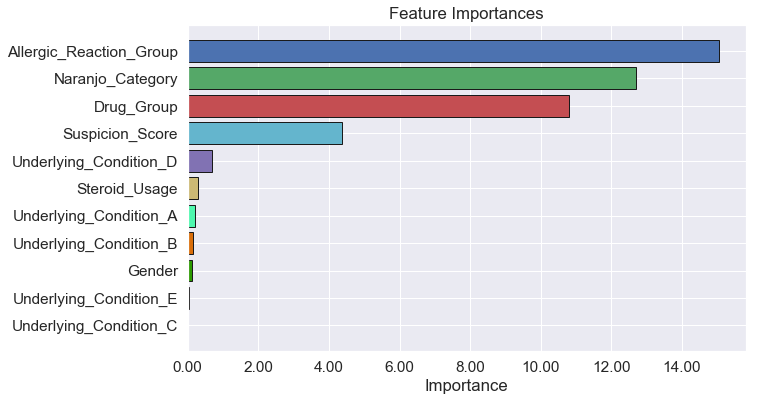

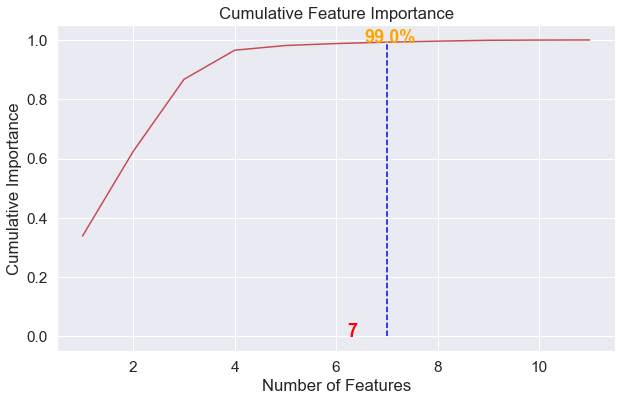

7 features required for 0.99 of cumulative importance


In [25]:
df_Chi2_feaimp = pd.DataFrame({'feature': feature_list_chi, 
                               'importance': feature_list_chi_score})\
                                .sort_values('importance', ascending = False)

df_Chi2_feaimp_norm = plot_feature_importances(df_Chi2_feaimp, threshold= 0.99, normalized=False)

In [26]:
category_feature = ['Gender','Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group']
print(category_feature)
category_feature.remove('Naranjo_Category')
print(category_feature)

['Gender', 'Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group']
['Gender', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group']


In [27]:
start = time()
pvalue = 0.05
feature_list_chi, feature_list_chi_score = chi2_indtest(df[category_feature],df['Naranjo_Category'], pvalue = pvalue)
t = time() - start
print('Execution time = ', t, ' seconds')

print('Select only IMPORTANT feature which p-value less than', pvalue)
print('Number of IMPORTANT feature for Prediction:', len(feature_list_chi), '\n',feature_list_chi)

Execution time =  0.14232921600341797  seconds
Select only IMPORTANT feature which p-value less than 0.05
Number of IMPORTANT feature for Prediction: 5 
 ['Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_D', 'Allergic_Reaction_Group', 'Drug_Group']


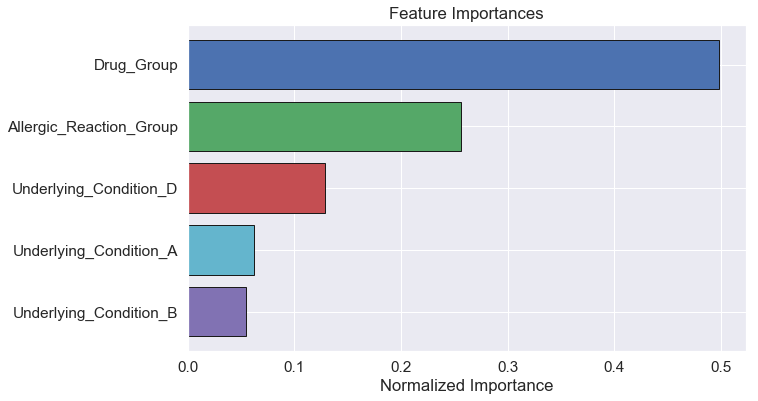

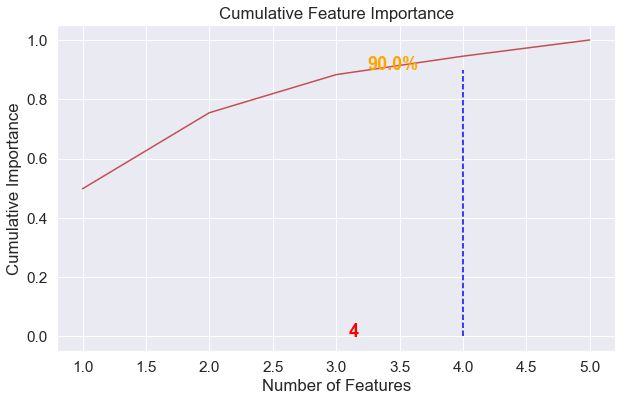

4 features required for 0.90 of cumulative importance


In [28]:
df_Chi2_feaimp = pd.DataFrame({'feature': feature_list_chi, 
                               'importance': feature_list_chi_score})\
                                .sort_values('importance', ascending = False)

df_Chi2_feaimp_norm = plot_feature_importances(df_Chi2_feaimp, threshold= 0.90, normalized=True)

## Explore  `Naranjo_Score` and `Naranjo_Category` 

In [29]:
labels = [str(i)+': ' + name for i,name in zip(range(4), ['Doubtful', 'Possible', 'Probable', 'Definite'])]
labels

['0: Doubtful', '1: Possible', '2: Probable', '3: Definite']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


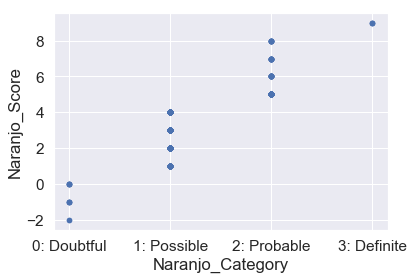

In [30]:
# df.plot(x='Naranjo_Category', y ='Naranjo_Score', c='Drug_Rechallenge_Result', kind='scatter')
ax = df.plot(x='Naranjo_Category', y ='Naranjo_Score', kind='scatter')
ax.set_xticks(range(4));
ax.set_xticklabels(labels);

In [31]:
# Naranjo_Score and Naranjo_Category have high-correlation, which Naranjo Category is a grouping category of Naranjo Score.
# Impute Naranjo_Category by Naranjo_Score
print(df[['Naranjo_Score','Naranjo_Category']].isnull().sum(axis='index'))
df[df[['Naranjo_Score','Naranjo_Category']].isnull().sum(axis='columns') == 1][['Naranjo_Score','Naranjo_Category']]

Naranjo_Score       368
Naranjo_Category    290
dtype: int64


,Naranjo_Score,Naranjo_Category
32,nan,2.000
48,nan,2.000
57,nan,2.000
58,nan,2.000
59,nan,1.000
60,nan,2.000
61,nan,2.000
63,nan,2.000
77,nan,2.000
78,nan,2.000


In [32]:
def Categorize_Naranjo_Score(score):
    if score <= 0:
        return 0
    elif score in range(1,5):
        return 1
    elif score in range(5,9):
        return 2
    elif score in range(9,11):
        return 3
    else:
        return score

# df = pd.read_csv('DrugAllergyKaggle_v3_050720.csv')
# df = df.sort_values(by = 'Patient_ID')
# df['Naranjo_Category'] = df.Naranjo_Score.apply(Categorize_Naranjo_Score) # ใช้ไม่ได้ เพราะจะแปลง cat ให้เป็น nan ด้วย
df.Naranjo_Category.fillna(value = df.Naranjo_Score.apply(Categorize_Naranjo_Score), inplace =True)

# df[df[['Naranjo_Score','Naranjo_Category']].isnull().sum(axis='columns') == 1][['Naranjo_Score','Naranjo_Category']]
df.iloc[493:494,:][['Naranjo_Score','Naranjo_Category']]

,Naranjo_Score,Naranjo_Category
493,-3.000,0.000


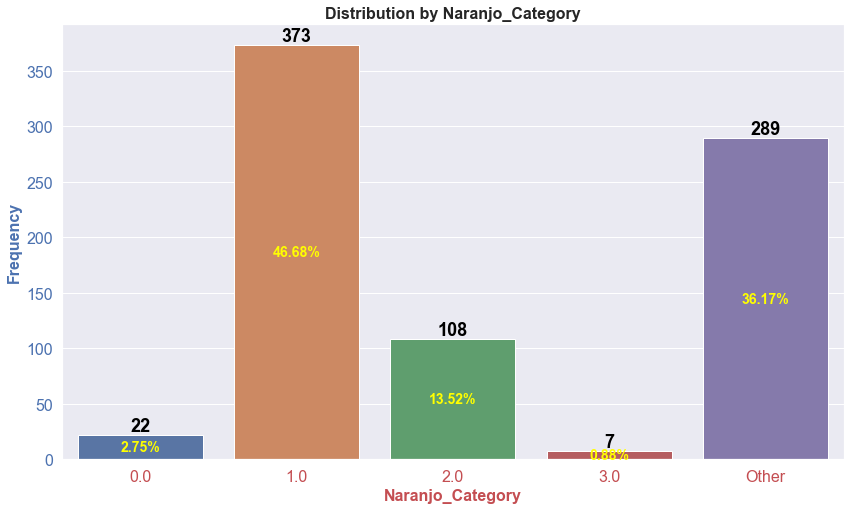

In [33]:
percent_countplot(df, col_name='Naranjo_Category',topn=9)
# sns.countplot(df.Naranjo_Category)
# df['Naranjo_Category'].value_counts(dropna=False).sort_index()

In [34]:
df.isnull().sum().values.sum()

1581

In [35]:
# We can drop Naranjo_Score now
df.drop('Naranjo_Score', axis=1 ,inplace=True)

## Impute
- One Hot Encoder & Oversampling

In [36]:
# Before we use 'get_dummies' function we have to convert data type of all feature to be 'category' 
def cvt_type(df, col_list, dtype = 'category'):
    for col in col_list:
        df[col] = df[col].astype('category')
    return df

In [37]:
def makeOverSamplesADASYN(X,y):
    from imblearn.over_sampling import ADASYN
    """
    Purpose
    ----------
    Increasing the observation of minority class 

    Parameters
    ----------
    X: Independent Variable in DataFrame
    y: Dependent Variable in Pandas DataFrame format
    Returns:
    ----------
    Returns Independent and Dependent with resampling minarity class
    """
    X_resampled, y_resampled = ADASYN().fit_sample(X, y)
    return(X_resampled, y_resampled)

In [38]:
feature_list_chi

['Underlying_Condition_A',
 'Underlying_Condition_B',
 'Underlying_Condition_D',
 'Allergic_Reaction_Group',
 'Drug_Group']

In [39]:
# Define feature
print('Original data: ', df.shape)
df_temp_Naranjo_Category = df[feature_list_chi + ['Naranjo_Category']].copy()
df_train = df_temp_Naranjo_Category.dropna(subset = ['Naranjo_Category'])

# Store unknown Naranjo_Category to df_unk
NaN_index = df_temp_Naranjo_Category[~df.index.isin(df_train.index)].index
df_unk = df_temp_Naranjo_Category.loc[NaN_index] # Select index that not in df_train


# Drop na row
df_train = df_temp_Naranjo_Category.dropna()
print('df_train dropna: ', df_train.shape)
print('Unknown Naranjo: ', df_unk.shape)

# Focus only Naranjo_Category class 1&2
df_train_w1_2 = df_train[df_train.Naranjo_Category.isin([1,2])]
print('Naranjo Cat1&2: ', df_train_w1_2.shape)

# Convert data type to category
df_train_cvt = cvt_type(df_train_w1_2, col_list=feature_list_chi)
X_data = df_train_cvt.drop('Naranjo_Category', axis= 1)
y_data = df_train_cvt[['Naranjo_Category']]

df_unk_cvt = cvt_type(df_unk, col_list=feature_list_chi)
X_unk_data = df_unk_cvt.drop('Naranjo_Category', axis= 1)

# Get dummies
X_encoded = pd.get_dummies(X_data, prefix_sep='_', drop_first=False)
X_unk_encoded = pd.get_dummies(X_unk_data, prefix_sep='_', drop_first=False)
print('Train encode: ', X_encoded.shape)
print('Class shape: ', y_data.shape)
print('Unknown encode: ', X_unk_encoded.shape)

Original data:  (799, 17)
df_train dropna:  (495, 6)
Unknown Naranjo:  (289, 6)
Naranjo Cat1&2:  (466, 6)
Train encode:  (466, 22)
Class shape:  (466, 1)
Unknown encode:  (289, 22)


/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [40]:
X_resampled, y_resampled = makeOverSamplesADASYN(X_encoded,y_data)
print(y_resampled['Naranjo_Category'].value_counts())

from sklearn.linear_model import LogisticRegression
LogReg_clf = LogisticRegression(random_state=7, fit_intercept=False)
LogReg_clf.fit(X_resampled, y_resampled)
print(accuracy_score(LogReg_clf.predict(X_resampled),y_resampled))
print(classification_report(LogReg_clf.predict(X_resampled),y_resampled))

Using TensorFlow backend.


1.000    360
2.000    356
Name: Naranjo_Category, dtype: int64
0.664804469273743
              precision    recall  f1-score   support

         1.0       0.80      0.63      0.71       456
         2.0       0.53      0.72      0.61       260

    accuracy                           0.66       716
   macro avg       0.66      0.68      0.66       716
weighted avg       0.70      0.66      0.67       716



/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
# Test with data before oversampling
print(classification_report(LogReg_clf.predict(X_encoded),y_data))

              precision    recall  f1-score   support

         1.0       0.80      0.76      0.78       378
         2.0       0.15      0.18      0.16        88

    accuracy                           0.65       466
   macro avg       0.48      0.47      0.47       466
weighted avg       0.68      0.65      0.66       466



In [42]:
df['Naranjo_Category'][NaN_index] = LogReg_clf.predict(X_unk_encoded) #df_unk_impute.Naranjo_Category
df.Naranjo_Category.isnull().sum()
# df.loc[NaN_index].head()

/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0

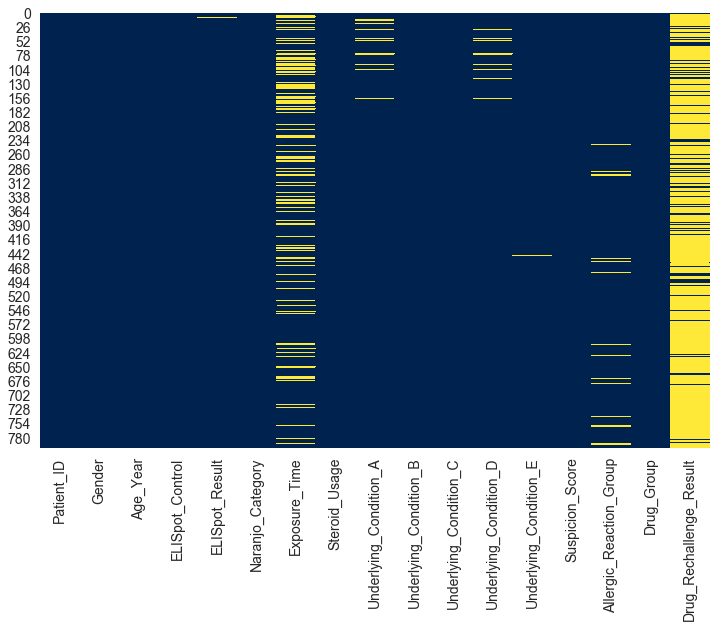

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap = 'cividis');

# Explore `ELISpot_Control` and `ELISpot_Result`

In [44]:
df.head()

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
0,2,1,26,2504,0.000,1.000,31.000,1,0.000,0,0,0.000,0.000,2,2.000,2,nan
1,7,0,75,1868,51.000,2.000,1.000,0,0.000,0,0,0.000,0.000,2,6.000,4,1.000
2,13,0,81,1617,10.000,1.000,19.000,1,1.000,0,0,1.000,1.000,2,5.000,1,nan
3,13,0,81,1617,10.000,1.000,19.000,1,1.000,0,0,1.000,1.000,2,5.000,3,nan
4,18,1,60,3136,0.000,1.000,nan,0,0.000,0,0,1.000,1.000,3,8.000,1,nan


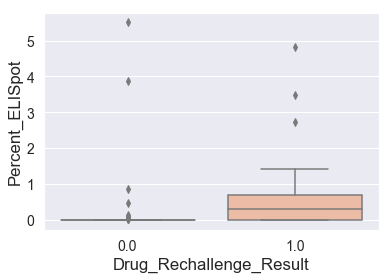

In [45]:
df_temp =df.copy()
df_temp['Percent_ELISpot'] = df_temp.ELISpot_Result / df_temp.ELISpot_Control *100
# df[df.Drug_Rechallenge_Result == 1]
# sns.boxplot(x="Drug_Rechallenge_Result", y="Percent_ELISpot",data=df, palette="coolwarm")
# remove outlier
sns.boxplot(x="Drug_Rechallenge_Result", y="Percent_ELISpot",data=df_temp[df_temp['Percent_ELISpot']<10], palette="coolwarm")

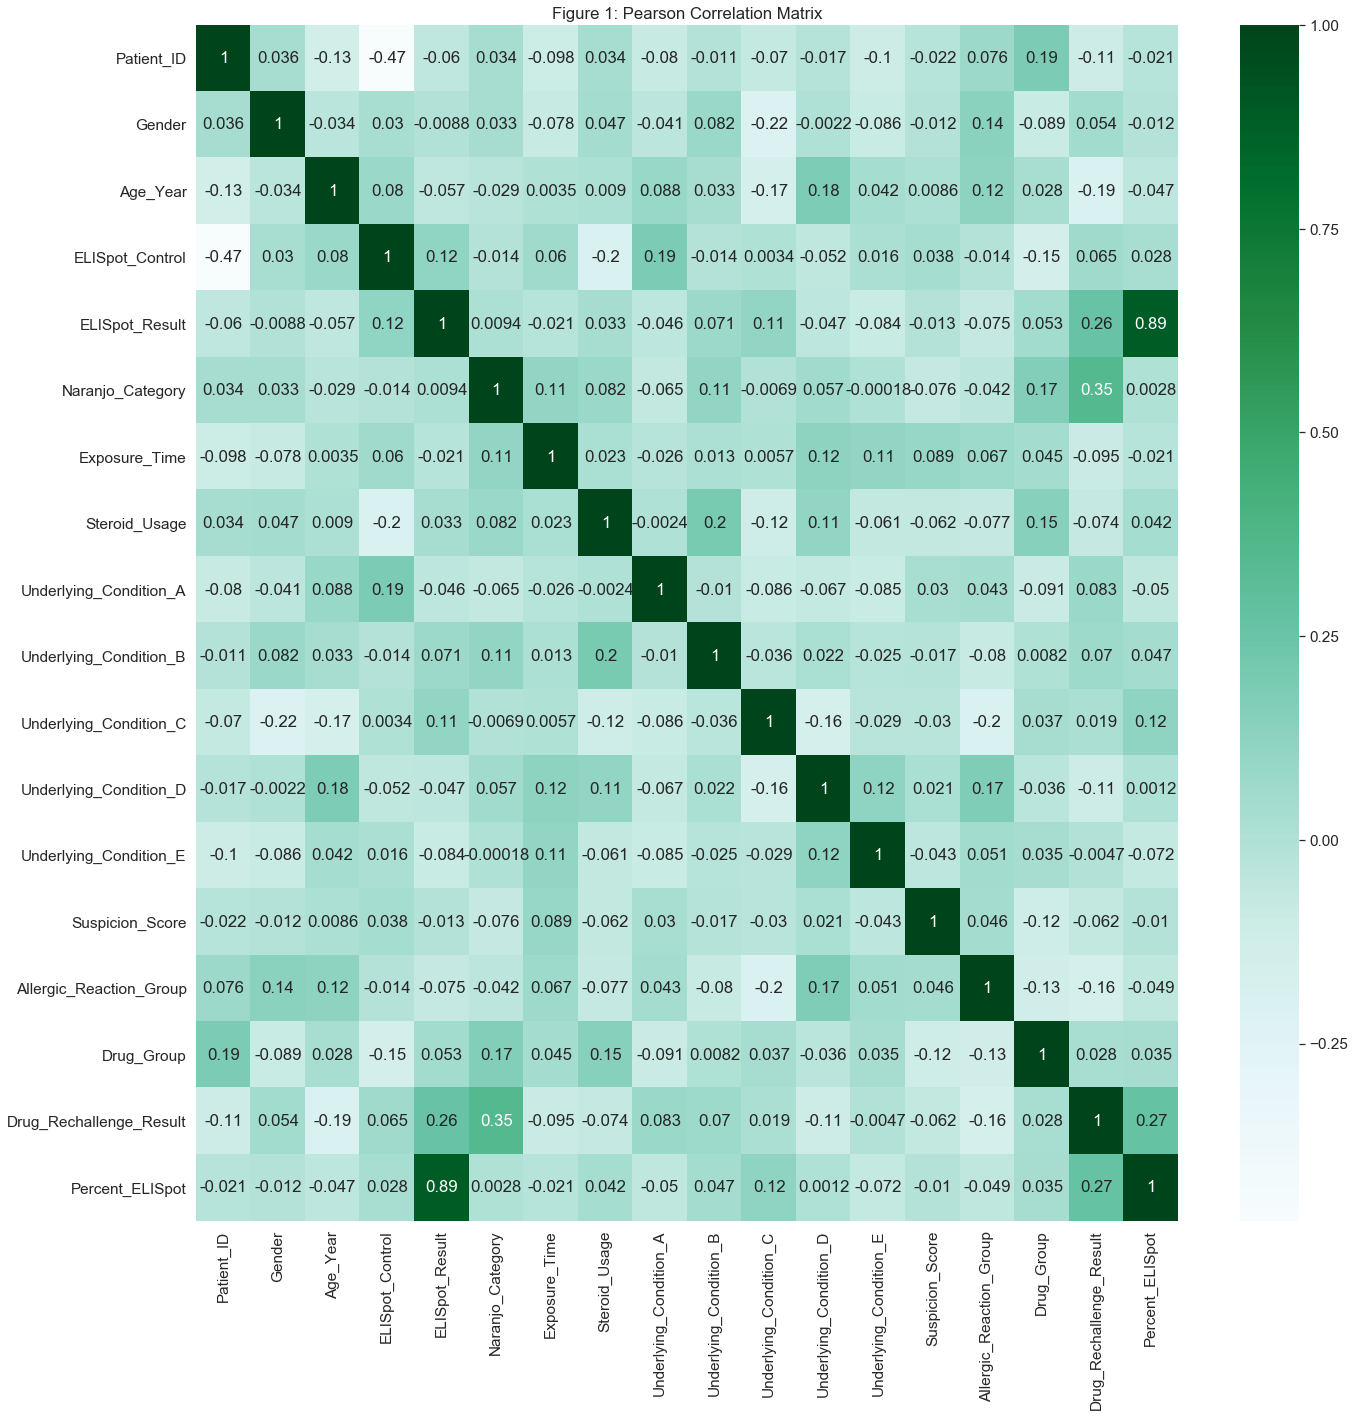

In [46]:
plt.figure(figsize=(22,22)) 
sns.set(font_scale=1.4)
plt.title('Figure 1: Pearson Correlation Matrix')
sns.heatmap(df_temp.corr(), annot=True, cmap='BuGn')

# Explore `Exposure_Time`

In [47]:
Exposure_Time_corr = df.corr()[['Exposure_Time']]
Exposure_Time_corr[np.abs(Exposure_Time_corr.Exposure_Time) > 0.1]

,Exposure_Time
Naranjo_Category,0.107
Exposure_Time,1.000
Underlying_Condition_D,0.123
Underlying_Condition_E,0.108


In [48]:
# Convert negative time to zero

ExT_neg_idx = df[df['Exposure_Time'] < 0][['Exposure_Time']].index

display(df.loc[ExT_neg_idx])

df.Exposure_Time = df.Exposure_Time.apply(lambda x: max(0,x))
df.loc[ExT_neg_idx]

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
202,319,1,56,1664,0.000,2.000,-9.000,1,0.000,1,0,0.000,1.000,2,1.000,8,nan
275,352,0,13,2060,0.000,0.000,-3.000,0,0.000,0,0,0.000,0.000,2,1.000,1,nan


,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
202,319,1,56,1664,0.000,2.000,0.000,1,0.000,1,0,0.000,1.000,2,1.000,8,nan
275,352,0,13,2060,0.000,0.000,0.000,0,0.000,0,0,0.000,0.000,2,1.000,1,nan


#### Bad result from LinearRegression model
- Try to discretize Exposure_Time and impute value with classifier instead
- Discretize to 4 categories
    - < 1hr (60 min)
    - 1 - 6 hrs (60 - 360 mins)
    - 6 - 24 hrs (360 - 1440 mins)
    - \> 24 hrs (1440 mins)

In [49]:
def discretize_time(time):
    if time < 60:
        return 0 #'less_1hr'
    elif 60 <= time < 360:
        return 1 #'1_6hrs'
    elif 360 <= time < 1440:
        return 2 #'6_24hrs'
    elif time >= 1440:
        return 3 #'over_24hrs'
    else:
        return time

In [50]:
df['Ex_Time_group'] = df.Exposure_Time.apply(discretize_time)
df.head()

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result,Ex_Time_group
0,2,1,26,2504,0.000,1.000,31.000,1,0.000,0,0,0.000,0.000,2,2.000,2,nan,0
1,7,0,75,1868,51.000,2.000,1.000,0,0.000,0,0,0.000,0.000,2,6.000,4,1.000,0
2,13,0,81,1617,10.000,1.000,19.000,1,1.000,0,0,1.000,1.000,2,5.000,1,nan,0
3,13,0,81,1617,10.000,1.000,19.000,1,1.000,0,0,1.000,1.000,2,5.000,3,nan,0
4,18,1,60,3136,0.000,1.000,0.000,0,0.000,0,0,1.000,1.000,3,8.000,1,nan,0


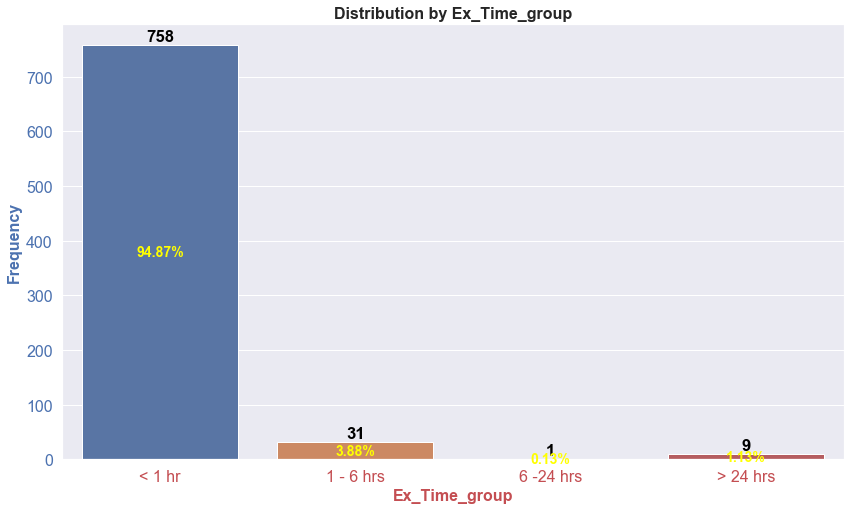

In [51]:
# Exposure_Time in hour unit
ax = percent_countplot(df[["Ex_Time_group"]], col_name='Ex_Time_group', topn=0)

labels = ['< 1 hr', '1 - 6 hrs', '6 -24 hrs', '> 24 hrs']
# https://stackoverflow.com/questions/45056579/is-it-possible-to-format-the-labels-using-set-xticklabels-in-matplotlib
ax.set_xticklabels(labels);

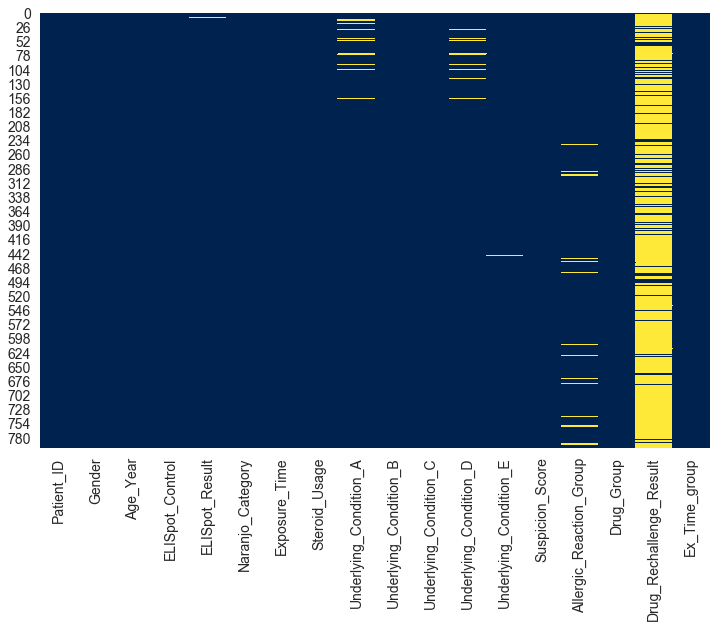

In [52]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap = 'cividis');

In [53]:
# Due to linear regression for predict Exposure_Time has low R-square (less than 0.10)
# I decide to use statistical imputation technique instead

df.Ex_Time_group.fillna(df.Ex_Time_group.mode()[0], inplace=True)

In [54]:
# We will use Ex_Time_group instead of Exposure_Time. So, we can drop Exposure_Time now
df.drop('Exposure_Time', axis=1 ,inplace=True)

In [55]:
df.isnull().sum()

Patient_ID                 0  
Gender                     0  
Age_Year                   0  
ELISpot_Control            0  
ELISpot_Result             1  
Naranjo_Category           0  
Steroid_Usage              0  
Underlying_Condition_A     18 
Underlying_Condition_B     0  
Underlying_Condition_C     0  
Underlying_Condition_D     14 
Underlying_Condition_E     1  
Suspicion_Score            0  
Allergic_Reaction_Group    28 
Drug_Group                 0  
Drug_Rechallenge_Result    685
Ex_Time_group              0  
dtype: int64

In [56]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
# print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
n_uniq = df.nunique()
print ("\nUnique values :  \n",n_uniq)
print ("\nTotal Unique values :  {:,}".format(n_uniq.values.sum()))

Rows     :  799
Columns  :  17

Missing values :   747

Unique values :  
 Patient_ID                 298
Gender                     2  
Age_Year                   94 
ELISpot_Control            261
ELISpot_Result             77 
Naranjo_Category           4  
Steroid_Usage              2  
Underlying_Condition_A     2  
Underlying_Condition_B     2  
Underlying_Condition_C     2  
Underlying_Condition_D     2  
Underlying_Condition_E     2  
Suspicion_Score            3  
Allergic_Reaction_Group    8  
Drug_Group                 8  
Drug_Rechallenge_Result    2  
Ex_Time_group              4  
dtype: int64

Total Unique values :  773


In [57]:
df.Ex_Time_group.fillna(df.Ex_Time_group.mode()[0], inplace=True)

In [58]:
# Use statistical imputation technique
df.Underlying_Condition_A.fillna(df.Underlying_Condition_A.mode()[0], inplace=True)
df.Underlying_Condition_D.fillna(df.Underlying_Condition_D.mode()[0], inplace=True)
df.Underlying_Condition_E.fillna(df.Underlying_Condition_E.mode()[0], inplace=True)
df.Allergic_Reaction_Group.fillna(df.Allergic_Reaction_Group.mode()[0], inplace=True)

# Drop 1 row for null value in ELISpot_Result
df.dropna(subset=['ELISpot_Result'], inplace=True)

In [59]:
df.isnull().sum()

Patient_ID                 0  
Gender                     0  
Age_Year                   0  
ELISpot_Control            0  
ELISpot_Result             0  
Naranjo_Category           0  
Steroid_Usage              0  
Underlying_Condition_A     0  
Underlying_Condition_B     0  
Underlying_Condition_C     0  
Underlying_Condition_D     0  
Underlying_Condition_E     0  
Suspicion_Score            0  
Allergic_Reaction_Group    0  
Drug_Group                 0  
Drug_Rechallenge_Result    684
Ex_Time_group              0  
dtype: int64

In [60]:
df.shape

(798, 17)

# Developing Model

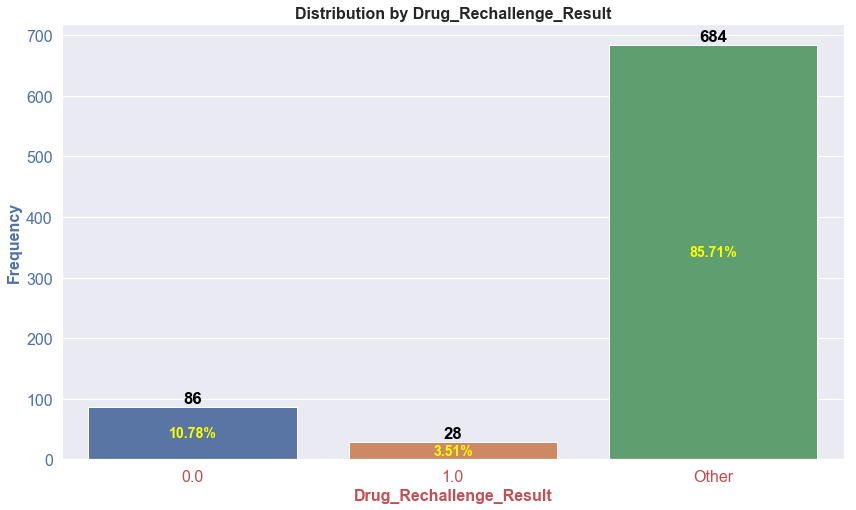

In [61]:
percent_countplot(df, col_name='Drug_Rechallenge_Result', topn=3)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 798
Data columns (total 17 columns):
Patient_ID                 798 non-null int64
Gender                     798 non-null int64
Age_Year                   798 non-null int64
ELISpot_Control            798 non-null int64
ELISpot_Result             798 non-null float64
Naranjo_Category           798 non-null float64
Steroid_Usage              798 non-null int64
Underlying_Condition_A     798 non-null float64
Underlying_Condition_B     798 non-null int64
Underlying_Condition_C     798 non-null int64
Underlying_Condition_D     798 non-null float64
Underlying_Condition_E     798 non-null float64
Suspicion_Score            798 non-null int64
Allergic_Reaction_Group    798 non-null float64
Drug_Group                 798 non-null int64
Drug_Rechallenge_Result    114 non-null float64
Ex_Time_group              798 non-null int64
dtypes: float64(7), int64(10)
memory usage: 112.2 KB


In [63]:
col_fea = df.columns.tolist()
X_data = df.drop(['Patient_ID','Drug_Rechallenge_Result'], axis=1)
y_data = df[['Drug_Rechallenge_Result']]

# K-mean algorithm

In [64]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(X_data)
data_transformed = mms.transform(X_data)

# kmeans = KMeans(n_clusters=2)
# kmeans.fit(X_data)

In [65]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

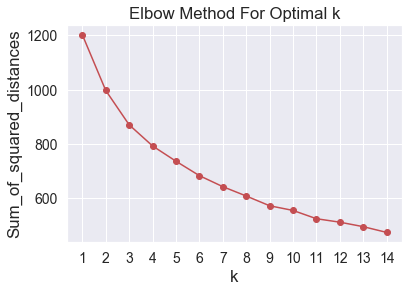

In [66]:
plt.plot(K, Sum_of_squared_distances, 'ro-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1,15))
plt.show()

# Fix k = 2

In [67]:
k_2 = KMeans(n_clusters=2)
k_2 = k_2.fit(data_transformed)

In [68]:
class_predict = k_2.labels_
class_predict[[0,1,2,3]]

array([0, 1, 1, 1], dtype=int32)

In [69]:
idx_data = y_data.dropna().index
class_data = y_data.loc[idx_data]

In [70]:
class_predict[idx_data]

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0], dtype=int32)

In [71]:
total = len(class_data.loc[idx_data])
class_predict = class_predict[idx_data].reshape(-1,1)
class_data = class_data.loc[idx_data].values
print(f'Accuracy: {(class_predict == class_data).sum()/total:.3f}')

Accuracy: 0.544


In [72]:
print(class_predict.shape, len(class_predict))
print(class_data.shape, len(class_data))

(114, 1) 114
(114, 1) 114


In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(class_predict,class_data))
print(classification_report(class_predict,class_data))

0.543859649122807
              precision    recall  f1-score   support

           0       0.62      0.74      0.67        72
           1       0.32      0.21      0.26        42

    accuracy                           0.54       114
   macro avg       0.47      0.48      0.46       114
weighted avg       0.51      0.54      0.52       114



# Preprocess - split train and unknown

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 798
Data columns (total 17 columns):
Patient_ID                 798 non-null int64
Gender                     798 non-null int64
Age_Year                   798 non-null int64
ELISpot_Control            798 non-null int64
ELISpot_Result             798 non-null float64
Naranjo_Category           798 non-null float64
Steroid_Usage              798 non-null int64
Underlying_Condition_A     798 non-null float64
Underlying_Condition_B     798 non-null int64
Underlying_Condition_C     798 non-null int64
Underlying_Condition_D     798 non-null float64
Underlying_Condition_E     798 non-null float64
Suspicion_Score            798 non-null int64
Allergic_Reaction_Group    798 non-null float64
Drug_Group                 798 non-null int64
Drug_Rechallenge_Result    114 non-null float64
Ex_Time_group              798 non-null int64
dtypes: float64(7), int64(10)
memory usage: 152.2 KB


In [75]:
df.to_csv('DrugAllergyKaggle_v3_050720_Imputed.csv', index=False)

In [76]:
df_sel = df.drop(['Patient_ID'], axis=1).copy()
df_train = df_sel.dropna(subset = ['Drug_Rechallenge_Result'])
df_unk = df_sel.iloc[~df.index.isin(df_train.index)] # Select index that not in df_train
print(df.shape)
print(df_train.shape)
print(df_unk.shape)

(798, 17)
(114, 16)
(684, 16)


# One Hot Encoding

In [77]:
# Before we use 'get_dummies' function we have to convert data type of all feature to be 'category' 
def cvt_type(df, col_list, dtype = 'category'):
    for col in col_list:
        df[col] = df[col].astype('category')
    return df

In [78]:
cat_col = ['Gender', 'Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A',
       'Underlying_Condition_B', 'Underlying_Condition_C',
       'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score',
       'Allergic_Reaction_Group', 'Drug_Group','Ex_Time_group']

df_train_cvt = cvt_type(df_train, col_list=cat_col)

/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [79]:
df_train_cvt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 1 to 789
Data columns (total 16 columns):
Gender                     114 non-null category
Age_Year                   114 non-null int64
ELISpot_Control            114 non-null int64
ELISpot_Result             114 non-null float64
Naranjo_Category           114 non-null category
Steroid_Usage              114 non-null category
Underlying_Condition_A     114 non-null category
Underlying_Condition_B     114 non-null category
Underlying_Condition_C     114 non-null category
Underlying_Condition_D     114 non-null category
Underlying_Condition_E     114 non-null category
Suspicion_Score            114 non-null category
Allergic_Reaction_Group    114 non-null category
Drug_Group                 114 non-null category
Drug_Rechallenge_Result    114 non-null float64
Ex_Time_group              114 non-null category
dtypes: category(12), float64(2), int64(2)
memory usage: 7.6 KB


In [80]:
X_data = df_train_cvt.drop('Drug_Rechallenge_Result',axis=1)
y_data = df_train_cvt[['Drug_Rechallenge_Result']]

In [81]:
# Get dummies
X_encoded = pd.get_dummies(X_data, prefix_sep='_', drop_first=False)
print(len(X_encoded.columns))

43


In [82]:
X_encoded.head()

,Age_Year,ELISpot_Control,ELISpot_Result,Gender_0,Gender_1,Naranjo_Category_0.0,Naranjo_Category_1.0,Naranjo_Category_2.0,Naranjo_Category_3.0,Steroid_Usage_0,Steroid_Usage_1,Underlying_Condition_A_0.0,Underlying_Condition_A_1.0,Underlying_Condition_B_0,Underlying_Condition_B_1,Underlying_Condition_C_0,Underlying_Condition_C_1,Underlying_Condition_D_0.0,Underlying_Condition_D_1.0,Underlying_Condition_E_0.0,Underlying_Condition_E_1.0,Suspicion_Score_1,Suspicion_Score_2,Suspicion_Score_3,Allergic_Reaction_Group_1.0,Allergic_Reaction_Group_2.0,Allergic_Reaction_Group_3.0,Allergic_Reaction_Group_4.0,Allergic_Reaction_Group_5.0,Allergic_Reaction_Group_6.0,Allergic_Reaction_Group_7.0,Allergic_Reaction_Group_8.0,Drug_Group_1,Drug_Group_2,Drug_Group_3,Drug_Group_4,Drug_Group_5,Drug_Group_6,Drug_Group_7,Drug_Group_8,Ex_Time_group_0,Ex_Time_group_1,Ex_Time_group_3
1,75,1868,51.000,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
17,72,856,0.000,1,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
22,72,1920,0.000,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
25,72,1920,0.000,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
29,78,3416,1.000,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0


# Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
# Logistic Regression
def LogReg_HPTune(X, y, verbose = 0):
    """
    Purpose
    ----------
    Choosing a set of optimal hyperparameters for a Logistic Regression Classifier

    Parameters
    ----------
    X: Data set with all feature or predictor
    y: Data set with Class
    verbose: 0 mean not show summary of tuning
             1 mean show summary of tuning
    Returns:
    ----------
    Returns grid search model of Logistic Regression Classifier with tuned hyperparameter
    """  
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    
    # Logistic Regression Classifier
    LogReg_clf = LogisticRegression(random_state = 7)
    
    # Create regularization hyperparameter space
    C = np.logspace(-5, 5, 100)
    
    # Create regularization penalty space
    penalty = ['none', 'l2']
    
    # Create class weight mode space
    class_weight = [None, 'balanced']
    
    # Create solver function space
    solver = ['saga', 'lbfgs', 'newton-cg']
    
    # 
    fit_intercept = ['True', False]

    
    # Define Search Param
    param_dist = dict(C = C,
                      penalty = penalty,
                      class_weight = class_weight,
#                       solver = solver,
                      fit_intercept = fit_intercept,
                     )
    rs = RandomizedSearchCV(estimator=LogReg_clf,
                            param_distributions=param_dist,
                            refit=True,
                            scoring=score_param,
                            n_iter=n_iter_search,
                            cv=cv,
                            n_jobs=-1,
                            verbose =1,
                            random_state=7,
                            iid=True)
    if verbose == 1:
        start = time()    
        rs.fit(X,y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))

    elif verbose == 0:
        rs.fit(X,y)
    
    # Best parameter from RandomizedSearchCV
    bs_C = rs.best_params_['C'] 
    bs_penalty = rs.best_params_['penalty'] 
    bs_class_weight = rs.best_params_['class_weight']
#     bs_solver = rs.best_params_['solver'] 
    bs_fit_intercept = rs.best_params_['fit_intercept']
    d_C = np.log10(bs_C)
    
    param_grid = dict(C = np.append(bs_C,np.logspace(d_C-2,d_C+2,num=100)),
                      penalty = [bs_penalty],
                      class_weight = [bs_class_weight],
#                       solver = [bs_solver],
                      fit_intercept = [bs_fit_intercept],
                     )
    gs = GridSearchCV(estimator=LogReg_clf, 
                      param_grid=param_grid,
                      refit=True,
                      scoring=score_param,
                      cv=cv,
                      n_jobs=-1,
                      verbose =1,
                      iid=True)
    
    if verbose == 1:
        start = time()
        gs.fit(X,y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))

    elif verbose == 0:
        gs.fit(X,y)
    
    return rs, gs



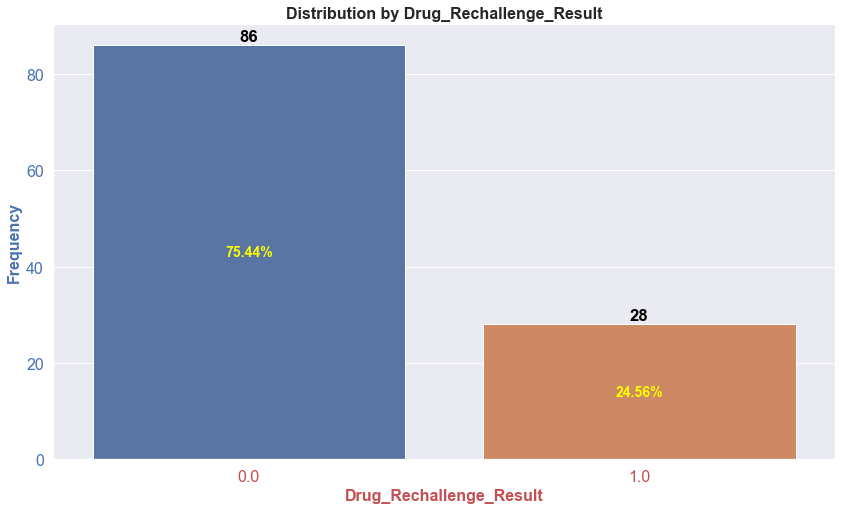

In [85]:
percent_countplot(y_data, col_name='Drug_Rechallenge_Result')

In [86]:
# accuracy
# balanced_accuracy
# average_precision
# roc_auc
# f1
# f1_micro
score_param = 'f1_micro' # Score for tune model
n_iter_search = 100 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation
LogReg_rs, LogReg_gs = LogReg_HPTune(X_encoded,y_data.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.4s finished
/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 101 candidates, totalling 505 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:   10.5s finished
/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [87]:
print(LogReg_gs.best_score_)
print(LogReg_rs.best_score_)
print(LogReg_rs.best_params_)
print(LogReg_gs.best_params_)
print(classification_report(LogReg_gs.predict(X_encoded),y_data))

0.8333333333333334
0.8245614035087719
{'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'C': 1.4174741629268048}
{'C': 0.23101297000831592, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89       103
         1.0       0.32      0.82      0.46        11

    accuracy                           0.82       114
   macro avg       0.65      0.82      0.68       114
weighted avg       0.91      0.82      0.85       114



In [88]:
# accuracy
# balanced_accuracy
# average_precision
# roc_auc
# f1
# f1_micro
score_param = 'balanced_accuracy' # Score for tune model
n_iter_search = 100 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation
LogReg_rs, LogReg_gs = LogReg_HPTune(X_encoded,y_data.values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:    7.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.6s finished
/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 101 candidates, totalling 505 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 498 out of 505 | elapsed:   10.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:   10.0s finished
/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [89]:
print(LogReg_gs.best_score_)
print(LogReg_rs.best_score_)
print(LogReg_rs.best_params_)
print(LogReg_gs.best_params_)
print(classification_report(LogReg_gs.predict(X_encoded),y_data))

0.7427846577227382
0.7427846577227382
{'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'C': 46.41588833612782}
{'C': 46.41588833612782, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.92        96
         1.0       0.57      0.89      0.70        18

    accuracy                           0.88       114
   macro avg       0.77      0.88      0.81       114
weighted avg       0.91      0.88      0.89       114



In [92]:
# save the model to disk
filename = './Model/LogReg_gs_with_bal_acc_false_intcp.pkl'
pickle.dump(LogReg_gs, open(filename, 'wb'))

# Load the model to disk
filename = './Model/LogReg_gs_with_bal_acc_false_intcp.pkl'
Logreg_Model = pickle.load(open(filename,"rb"))

# Naive Bayes

In [93]:
# Naive Bayes
def NB_HPTune(X, y, verbose = 0):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
    
    gnb = GaussianNB(priors=None)
    param_dist = dict(var_smoothing = np.logspace(-16,0,200) ) # default is 1e-9
    rs = RandomizedSearchCV(estimator=gnb,
                             param_distributions=param_dist,
                             scoring=score_param,
                             refit=True,
                             n_iter = n_iter_search,
                             cv=cv,
                             n_jobs=-1,
                             random_state=7,
                             iid=True)
    if verbose == 1:
        start = time()    
        rs.fit(X, y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))
    elif verbose == 0:
        rs.fit(X, y)
    
    # Best parameter from RandomizedSearchCV
    bs_var_sm = rs.best_params_['var_smoothing']
    bs_var_sm_pw = np.log10(bs_var_sm)
    
    param_grid = dict(var_smoothing = np.logspace(bs_var_sm_pw*0.9,bs_var_sm_pw*1.1,50))
    gs = GridSearchCV(estimator=gnb, 
                      param_grid=param_grid,
                      scoring=score_param,
                      refit=True,
                      cv=cv,
                      n_jobs=-1, 
                      iid=True)
    
    if verbose == 1:
        start = time()
        gs.fit(X, y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))
    elif verbose == 0:
        gs.fit(X, y)
    
    return rs, gs

In [94]:
# accuracy
# balanced_accuracy
# average_precision
# roc_auc
# f1
# f1_micro
score_param = 'balanced_accuracy' # Score for tune model
n_iter_search = 100 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation
NB_rs, NB_gs = NB_HPTune(X_encoded,y_data)

/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [95]:
print(NB_gs.best_score_)
print(NB_rs.best_score_)
print(NB_rs.best_params_)
print(NB_gs.best_params_)
print(classification_report(NB_gs.predict(X_encoded),y_data))

0.6471362229102167
0.6355263157894737
{'var_smoothing': 2.5529080682395163e-07}
{'var_smoothing': 3.589554145242082e-07}
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.88       104
         1.0       0.29      0.80      0.42        10

    accuracy                           0.81       114
   macro avg       0.63      0.80      0.65       114
weighted avg       0.92      0.81      0.84       114



# Support Vector Machine

In [96]:
# Support Vector Machine
def SVM_HPTune(X, y, verbose = 0):
    from sklearn.svm import SVC
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
    
    # Scale data
    scaler = StandardScaler()

    # Reduce dimensions (speed up)
    pca = PCA(n_components=0.9, random_state=7)

    # Support Vector Machine
    SVM = SVC(probability=True, random_state =7)
    
    pipeline = Pipeline([('SC_X', scaler), 
                         ('pca', pca), 
                         ('clf', SVM)]
                       )
    
    # Define Search Param
    param_dist = dict(clf__C = np.logspace(-5,5,num=50),
                      clf__gamma = np.logspace(-5,5,num=50),
                      clf__kernel = ['sigmoid', 'rbf','linear','poly'],
                      #clf__decision_function_shape = ('ovo','ovr')
                     )
    rs = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=param_dist,
                            refit=True,
                            scoring=score_param,
                            n_iter=n_iter_search,
                            cv=cv,
                            n_jobs=-1,
                            verbose =1,
                            random_state=7,
                            iid=True)
    if verbose == 1:
        start = time()    
        rs.fit(X,y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))

    elif verbose == 0:
        rs.fit(X,y)
    
    # Best parameter from RandomizedSearchCV
    bs_C = rs.best_params_['clf__C'] 
    bs_gamma = rs.best_params_['clf__gamma'] 
    bs_kernel = rs.best_params_['clf__kernel']
    #bs_dfs = rs.best_params_['clf__decision_function_shape'] 
    d_C = np.log10(bs_C)
    d_gamma = np.log10(bs_gamma)
    
    param_grid = dict(clf__C = np.append(bs_C,np.logspace(d_C-1,d_C+1,num=5)),
                      clf__gamma = np.append(bs_gamma,np.logspace(d_gamma-1,d_gamma+1,num=5)),
                      clf__kernel = [bs_kernel,'rbf'],
                      #clf__decision_function_shape = [bs_dfs]
                     )
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=param_grid,
                      refit=True,
                      scoring=score_param,
                      cv=cv,
                      n_jobs=-1,
                      verbose =1,
                      iid=True)
    
    if verbose == 1:
        start = time()
        gs.fit(X,y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))

    elif verbose == 0:
        gs.fit(X,y)
    
    return rs, gs

In [97]:
# accuracy
# balanced_accuracy
# average_precision
# roc_auc
# f1
# f1_micro
score_param = 'balanced_accuracy' # Score for tune model
n_iter_search = 100 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation
SVM_rs, SVM_gs = SVM_HPTune(X_data,y_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.3s


KeyboardInterrupt: 

In [ ]:
print(SVM_gs.best_score_)
print(SVM_rs.best_score_)
print(SVM_rs.best_params_)
print(SVM_gs.best_params_)
print(classification_report(SVM_gs.predict(X_data),y_data))

In [ ]:
LogisticRegression()